In [1]:
import librosa
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import IPython.display as ipd

The process is almost identical to the one followed in *Guitar_note_dataset_creator.ipynb*

In [2]:
def file_to_string_data(file, rs, samples):
    y, sr = librosa.load(file, mono=False)
    y = librosa.core.to_mono(y)
    y = librosa.resample(y, sr, rs)

    df = pd.DataFrame(columns=["x{}".format(i) for i in range(samples)]+["String"])
    string = file.split("/")[6].split("_")[2][-1]

    for i in tqdm(range(0, len(y), 4000), leave = False):
        note = y[i:i+4000]
        note = note[np.argwhere(note >= 0.001)[0][0]:]
        df = df.append(pd.DataFrame({**{"x{}".format(j): note[j] for j in range(samples)}, 
                                    **{"String": [string]}}))
    df = df.reset_index(drop=True)
    return df

In [5]:
test = file_to_string_data("../../../Samples/Guitar/Ind_notes/Guitar_noamp_string1_0.mp3", 8000, 500)
test.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x491,x492,x493,x494,x495,x496,x497,x498,x499,String
0,0.011885,0.065837,0.054477,0.001083,-0.008840,-0.011722,-0.009675,-0.009590,-0.007022,-0.006044,...,0.003017,0.002701,0.005264,0.002123,0.000808,-0.005113,-0.007833,-0.009136,-0.004496,1
1,0.001323,-0.000431,-0.000029,0.000628,0.000234,0.000056,-0.000356,0.000476,0.000641,-0.000924,...,0.000301,0.004450,0.002960,0.004106,0.001343,-0.001490,-0.011215,-0.050637,-0.044150,1
2,0.003131,0.001738,-0.001099,-0.000274,0.000259,-0.004622,-0.005271,0.000718,0.000946,-0.002456,...,-0.000201,-0.002048,-0.020184,-0.058821,-0.033748,0.008029,0.053200,0.058775,0.020833,1
3,0.004378,0.001292,-0.002531,0.000782,0.002359,-0.001751,-0.002561,0.000877,0.000323,-0.001466,...,0.052762,0.017658,0.001521,-0.002455,-0.001115,-0.002395,-0.005104,-0.003589,0.000789,1
4,0.001683,0.001334,0.000178,0.000211,0.000880,-0.001185,-0.002538,-0.001532,-0.001670,-0.002683,...,-0.000555,-0.000198,-0.000323,0.003346,0.001709,0.000084,-0.028971,-0.075274,-0.043371,1


In [8]:
def dir_to_string_data(directory, rs, samples):
    data = pd.DataFrame(columns=["x{}".format(i) for i in range(samples)]+["String"])
    pbar = tqdm(os.listdir(directory))
    
    for file in pbar:
        pbar.set_description("Processing %s" % file)
        df = file_to_string_data(directory + file, rs, samples)
        data = data.append(df)
        
    data = data.reset_index().drop("index", axis=1)
    return data

In [10]:
data = dir_to_string_data("../../../Samples/Guitar/Ind_notes/", 8000, 500)

In [11]:
data.shape

(7175, 501)

In [12]:
data.to_pickle("../../../Data/Guitar/guitar-string-data-500.pkl")

## Spectral data

In [5]:
string_data = pd.read_pickle("../../../Data/Guitar/guitar-string-data-500.pkl")

In [6]:
note_data = pd.read_pickle("../../../Data/Guitar/guitar-data-500.pkl")

Spectral data is useful because, as shown below, 2 identical notes played on different strings have different amplitudes for each frequency

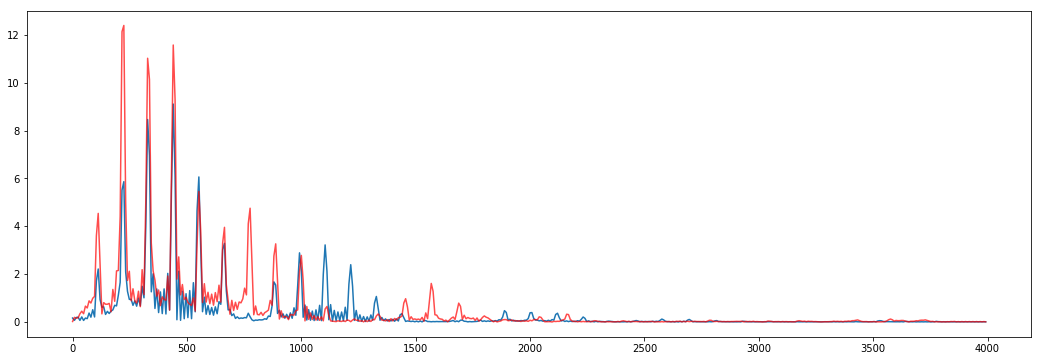

In [7]:
y = string_data[(string_data["String"] == "5") & (note_data["Note"] == "A2")].sample().drop("String", axis=1).values.flatten()
w = np.fft.fft(y, n=1000)
freqs = np.fft.fftfreq(len(w))
plt.figure(figsize=(18,6))
plt.plot(8000*freqs[freqs >= 0],abs(w[freqs >= 0]))

y = string_data[(string_data["String"] == "6") & (note_data["Note"] == "A2")].sample().drop("String", axis=1).values.flatten()
w = np.fft.fft(y, n=1000)
freqs = np.fft.fftfreq(len(w))
plt.plot(8000*freqs[freqs >= 0],abs(w[freqs >= 0]), 'r', alpha=.7)

In [3]:
def file_to_spectral_string_data(file, rs):
    y, sr = librosa.load(file, mono=False)
    y = librosa.core.to_mono(y)
    y = librosa.resample(y, sr, rs)

    df = pd.DataFrame(columns=["x{}".format(i) for i in range(500)]+["String"])
    string = file.split("/")[6].split("_")[2][-1]

    for i in tqdm(range(0, len(y), 4000), leave = False):
        note = y[i:i+500]
        note = note[np.argwhere(note >= 0.001)[0][0]:]
        # Fast Fourier Transform
        w = abs(np.fft.fft(note, n=1000))
        # Frequencies that correspond to the FFT
        freqs = np.fft.fftfreq(len(w))
        df = df.append(pd.DataFrame({**{"x{}".format(j): w[freqs >= 0][j] for j in range(500)}, 
                                    **{"String": [string]}}))
    df = df.reset_index(drop=True)
    return df

In [4]:
test = file_to_spectral_string_data("../../../Samples/Guitar/Ind_notes/Guitar_noamp_string1_0.mp3", 8000)
test.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x491,x492,x493,x494,x495,x496,x497,x498,x499,String
0,0.067711,0.047473,0.004226,0.035413,0.036588,0.028970,0.072126,0.097540,0.081796,0.066446,...,0.002373,0.003554,0.006362,0.004421,0.000848,0.005239,0.005508,0.001511,0.003875,1
1,0.017651,0.027496,0.021610,0.031240,0.042458,0.026902,0.053832,0.044609,0.021624,0.057025,...,0.001211,0.002182,0.000935,0.002376,0.000476,0.002173,0.000395,0.002224,0.000307,1
2,0.055812,0.002417,0.084570,0.073893,0.034538,0.064736,0.062508,0.005845,0.081436,0.093558,...,0.046404,0.043912,0.046391,0.043906,0.046238,0.043703,0.046115,0.043827,0.046019,1
3,0.016096,0.067265,0.067314,0.017624,0.014372,0.013101,0.056295,0.080404,0.064696,0.054805,...,0.004137,0.001049,0.003237,0.000526,0.003892,0.000398,0.003777,0.000568,0.003859,1
4,0.013773,0.025793,0.047515,0.041676,0.022184,0.039085,0.056063,0.069995,0.072289,0.060769,...,0.033065,0.034790,0.033022,0.034755,0.032869,0.034918,0.033568,0.034817,0.033033,1


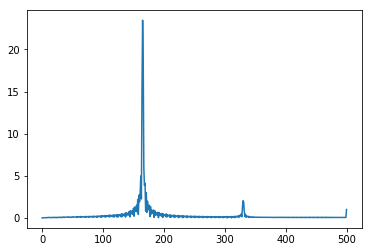

In [4]:
plt.plot(test.iloc[24].values)

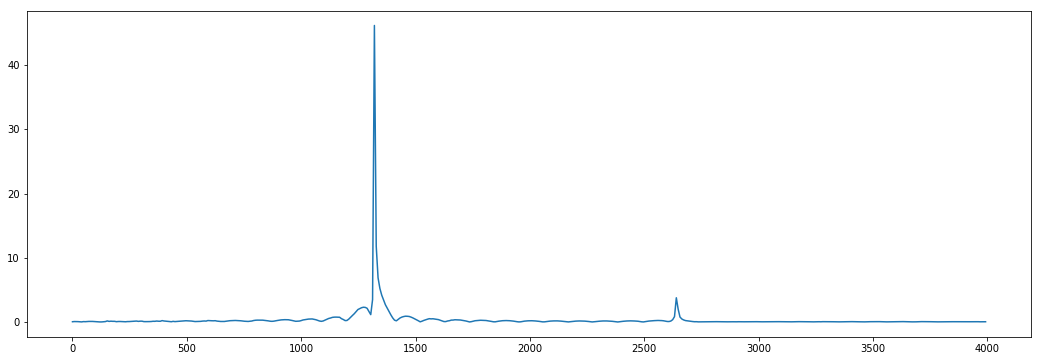

In [5]:
y, sr = librosa.load("../../../Samples/Guitar/Ind_notes/Guitar_noamp_string1_0.mp3", mono=False)
y = librosa.core.to_mono(y)
y = librosa.resample(y, sr, 8000)
note = y[24*4000:24*4000+4000]
w = np.fft.fft(note, n=1000)
freqs = np.fft.fftfreq(len(w))
plt.figure(figsize=(18,6))
plt.plot(8000*freqs[freqs >= 0],abs(w[freqs >= 0]))

In [6]:
def dir_to_spectral_string_data(directory, rs):
    data = pd.DataFrame(columns=["x{}".format(i) for i in range(500)]+["String"])
    pbar = tqdm(os.listdir(directory))
    
    for file in pbar:
        pbar.set_description("Processing %s" % file)
        df = file_to_spectral_string_data(directory + file, rs)
        data = data.append(df)
        
    data = data.reset_index().drop("index", axis=1)
    return data

In [7]:
data = dir_to_spectral_string_data("../../../Samples/Guitar/Ind_notes/", 8000)

In [8]:
data.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x491,x492,x493,x494,x495,x496,x497,x498,x499,String
0,0.067711,0.047473,0.004226,0.035413,0.036588,0.028970,0.072126,0.097540,0.081796,0.066446,...,0.002373,0.003554,0.006362,0.004421,0.000848,0.005239,0.005508,0.001511,0.003875,1
1,0.017651,0.027496,0.021610,0.031240,0.042458,0.026902,0.053832,0.044609,0.021624,0.057025,...,0.001211,0.002182,0.000935,0.002376,0.000476,0.002173,0.000395,0.002224,0.000307,1
2,0.055812,0.002417,0.084570,0.073893,0.034538,0.064736,0.062508,0.005845,0.081436,0.093558,...,0.046404,0.043912,0.046391,0.043906,0.046238,0.043703,0.046115,0.043827,0.046019,1
3,0.016096,0.067265,0.067314,0.017624,0.014372,0.013101,0.056295,0.080404,0.064696,0.054805,...,0.004137,0.001049,0.003237,0.000526,0.003892,0.000398,0.003777,0.000568,0.003859,1
4,0.013773,0.025793,0.047515,0.041676,0.022184,0.039085,0.056063,0.069995,0.072289,0.060769,...,0.033065,0.034790,0.033022,0.034755,0.032869,0.034918,0.033568,0.034817,0.033033,1


In [9]:
data.shape

(7175, 501)

In [10]:
data.to_pickle("../../../Data/Guitar/guitar-spectral-string-data-500.pkl")

## Spectral norm

Same as before but normalizing by dividing by the maximum value

In [5]:
def file_to_norm_spectral_string_data(file, rs):
    y, sr = librosa.load(file, mono=False)
    y = librosa.core.to_mono(y)
    y = librosa.resample(y, sr, rs)

    df = pd.DataFrame(columns=["x{}".format(i) for i in range(500)]+["String"])
    string = file.split("/")[6].split("_")[2][-1]

    for i in tqdm(range(0, len(y), 4000), leave = False):
        note = y[i:i+4000]
        note = note[np.argwhere(note >= 0.001)[0][0]:]
        w = abs(np.fft.fft(note, n=1000))
        freqs = np.fft.fftfreq(len(w)) 
        df = df.append(pd.DataFrame({**{"x{}".format(j): w[freqs >= 0][j]/np.max(w) for j in range(500)}, 
                                     **{"String": [string]}}))
    df = df.reset_index(drop=True)
    return df

In [6]:
test = file_to_norm_spectral_string_data("../../../Samples/Guitar/Ind_notes/Guitar_noamp_string1_0.mp3", 8000)
test.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x491,x492,x493,x494,x495,x496,x497,x498,x499,String
0,0.009313,0.005996,0.003646,0.003533,0.005225,0.005453,0.010079,0.008177,0.009172,0.010082,...,0.000271,0.000142,0.000138,0.000098,0.000356,0.000139,0.000109,0.000082,0.000053,1
1,0.002541,0.001798,0.003476,0.004131,0.004454,0.005336,0.008315,0.003602,0.005094,0.005036,...,0.000205,0.000201,0.000204,0.000160,0.000216,0.000214,0.000213,0.000209,0.000207,1
2,0.003780,0.001447,0.006733,0.007937,0.007448,0.006522,0.008060,0.003464,0.005282,0.009190,...,0.000134,0.000118,0.000105,0.000102,0.000100,0.000071,0.000099,0.000111,0.000109,1
3,0.009631,0.014050,0.005634,0.005016,0.007942,0.006121,0.005657,0.011655,0.015172,0.006616,...,0.004344,0.004222,0.004246,0.004203,0.004159,0.004156,0.004171,0.004172,0.004158,1
4,0.007069,0.010863,0.010101,0.007177,0.005984,0.006378,0.008708,0.014568,0.012019,0.011039,...,0.000979,0.000963,0.000983,0.000972,0.000985,0.001023,0.000938,0.000961,0.000968,1


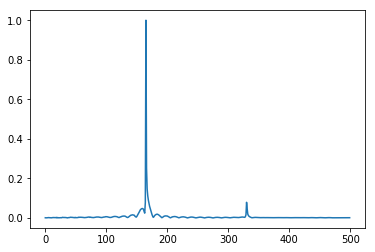

In [15]:
plt.plot(test.drop("String", axis=1).iloc[24].values)

In [20]:
def dir_to_norm_spectral_string_data(directory, rs):
    data = pd.DataFrame(columns=["x{}".format(i) for i in range(500)]+["String"])
    pbar = tqdm(os.listdir(directory))
    
    for file in pbar:
        pbar.set_description("Processing %s" % file)
        df = file_to_norm_spectral_string_data(directory + file, rs)
        data = data.append(df)
        
    data = data.reset_index().drop("index", axis=1)
    return data

In [21]:
data = dir_to_norm_spectral_string_data("../../../Samples/Guitar/Ind_notes/", 8000)

In [22]:
data.shape

(7175, 501)

In [23]:
data.to_pickle("../../../Data/Guitar/guitar-norm-spectral-string-data-500.pkl")

In [39]:
data_ind = pd.read_pickle("../../../Data/Guitar/guitar-norm-spectral-string-data-500.pkl")

Here I tried it with riff recordings, but it is not a good idea since note onsets are not always where they are supposed to be

In [3]:
onset_dict = {
    "riff1": [0, 4000, 6000, 10000, 12000, 14000, 16000, 20000, 21000, 22000, 32000],
    "riff2": [i for i in range(0, 32001, 2000)],
    "riff3": [i for i in range(0, 8001, 1000)] + [10000],
    "riff4": [0, 2000, 4000, 6000, 8000, 10000, 12000, 16000, 18000, 20000, 22000, 24000, 26000, 28000, 32000],
    "riff5": [i for i in range(0, 32001, 1000)],
    "riff7": [i for i in range(0, 16001, 2000)],
    "riff8": [0, 3000, 6000, 8000, 11000, 14000, 16000],
    "ind": [i for i in range(0, 24*4000, 4000)] + [24*4000+2000]
}

In [28]:
string_dict = {
    "riff1": [5] * 10,
    "riff2": [5, 3] * 8,
    "riff3": [6, 6, 6, 5, 5, 4, 4, 4, 3],
    "riff4": [5, 3, 3, 5, 3, 3, 2, 5, 3, 3, 5, 3, 3, 4],
    "riff5": [4] * 32,
    "riff7": [3, 2, 1, 3, 2, 1, 3, 1],
    "riff8": [3] * 6
}

In [8]:
%run ../../Utilities.ipynb

Using TensorFlow backend.


In [32]:
def riff_to_norm_spectral_data(file, rs, samples, onset_dict, string_dict):
    y = load_file(file, rs)
    df = pd.DataFrame()
    riff = file.split("/")[-1].split("_")[2].replace(".mp3", "")
    
    if riff in ["riff6", "riff9"]:
        return None
    
    for i in tqdm(range(len(onset_dict[riff]) - 1), leave = False):
        note = y[onset_dict[riff][i]:onset_dict[riff][i+1]]
        temp_data = spectral_data(note, samples, True)
        temp_data["String"] = string_dict[riff][i]
        df = df.append(temp_data)
        
    df = df.reset_index(drop=True)
    return df

In [33]:
test = riff_to_norm_spectral_data("../../../Samples/Guitar/Riffs/Guitar_noamp_riff1.mp3", 8000, 500, onset_dict, string_dict)

In [34]:
test.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x491,x492,x493,x494,x495,x496,x497,x498,x499,String
0,0.004083,0.010261,0.014739,0.011797,0.006868,0.017172,0.020780,0.028758,0.013104,0.011838,...,0.002529,0.002583,0.002540,0.002540,0.002544,0.002546,0.002550,0.002546,0.002548,5
1,0.014946,0.027780,0.010090,0.008782,0.005645,0.012436,0.010521,0.004551,0.009932,0.028908,...,0.004403,0.004406,0.004410,0.004412,0.004408,0.004410,0.004404,0.004408,0.004416,5
2,0.012888,0.022704,0.024538,0.011072,0.017833,0.008353,0.016692,0.021670,0.009812,0.020551,...,0.000361,0.000352,0.000351,0.000359,0.000355,0.000352,0.000350,0.000360,0.000353,5
3,0.031595,0.033630,0.013495,0.027147,0.019449,0.018600,0.028649,0.018900,0.028719,0.038444,...,0.001205,0.001190,0.001185,0.001188,0.001186,0.001183,0.001184,0.001188,0.001188,5
4,0.002120,0.010318,0.007260,0.000933,0.012586,0.013365,0.003102,0.017230,0.014732,0.008335,...,0.000026,0.000037,0.000041,0.000022,0.000032,0.000032,0.000032,0.000031,0.000022,5


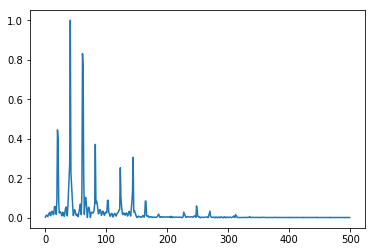

In [35]:
plt.plot(test.drop("String", axis=1).iloc[0].values)

In [36]:
data = dir_to_data("../../../Samples/Guitar/Riffs/", riff_to_norm_spectral_data, 8000, 500, onset_dict, string_dict)

In [37]:
data.shape

(1301, 501)

In [38]:
data.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x491,x492,x493,x494,x495,x496,x497,x498,x499,String
0,0.004083,0.010261,0.014739,0.011797,0.006868,0.017172,0.020780,0.028758,0.013104,0.011838,...,0.002529,0.002583,0.002540,0.002540,0.002544,0.002546,0.002550,0.002546,0.002548,5
1,0.014946,0.027780,0.010090,0.008782,0.005645,0.012436,0.010521,0.004551,0.009932,0.028908,...,0.004403,0.004406,0.004410,0.004412,0.004408,0.004410,0.004404,0.004408,0.004416,5
2,0.012888,0.022704,0.024538,0.011072,0.017833,0.008353,0.016692,0.021670,0.009812,0.020551,...,0.000361,0.000352,0.000351,0.000359,0.000355,0.000352,0.000350,0.000360,0.000353,5
3,0.031595,0.033630,0.013495,0.027147,0.019449,0.018600,0.028649,0.018900,0.028719,0.038444,...,0.001205,0.001190,0.001185,0.001188,0.001186,0.001183,0.001184,0.001188,0.001188,5
4,0.002120,0.010318,0.007260,0.000933,0.012586,0.013365,0.003102,0.017230,0.014732,0.008335,...,0.000026,0.000037,0.000041,0.000022,0.000032,0.000032,0.000032,0.000031,0.000022,5


In [40]:
data = data_ind.append(data)

In [41]:
data.shape

(8476, 501)

In [42]:
data.to_pickle("../../../Data/Guitar/guitar-norm-spectral-string-data-500.pkl")

### Adding accurate

The idea here was to use interactive data extraction to get string data, but I did not get to use it so far

In [9]:
%run ../../Utilities.ipynb

In [11]:
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, BoundedIntText
from ipykernel.pylab.backend_inline import flush_figures
from IPython.display import display
from ipywidgets import Button, jslink, Checkbox
%matplotlib inline

In [20]:
def add_data(y, x, string):
    data = pd.read_pickle("../../../Data/Guitar/guitar-norm-spectral-string-data-500.pkl")
    x = x - 30
    for dx in range(0, 60, 5):
        spec = spectral_data(y[x+dx:x+dx+500], 500, True)
        spec["String"] = int(string)
        data = data.append(spec)
    data.to_pickle("../../../Data/Guitar/guitar-norm-spectral-string-data-500.pkl")

In [21]:
def f(x):
    plt.figure(figsize=(18,6))
    plt.plot(y)
    plt.axvline(x=int(x), color="r")
    plt.axvline(x=int(x)+500, color="r")
    plt.show()

In [22]:
def on_button_clicked(b):
    add_data(y, int(slider.value), box.value)

In [58]:
y = load_file("../../../Samples/Guitar/Riffs/Guitar_noamp_riff17.mp3", 8000)

In [59]:
slider = FloatSlider(min=0, max=len(y), step=50, continuous_update=False)
interact(f, x=slider)
button = Button(description="Add data")
box = BoundedIntText(
    value=5,
    min=1,
    max=8,
    step=1,
    description='String:',
    disabled=False
)
display(box, button)
button.on_click(on_button_clicked)

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='x', max=16513.0, step=50.0)…

BoundedIntText(value=5, description='String:', max=8, min=1)

Button(description='Add data', style=ButtonStyle())

In [76]:
data = pd.read_pickle("../../../Data/Guitar/guitar-norm-spectral-string-data-500.pkl")

In [77]:
data.shape

(11980, 501)

## Spectral data for fret

Here I tried to extract data for a fret classifier, which would do the job of note and string ID, but in the end I did not use it.

In [2]:
note_table = pd.read_csv("../../../Data/Piano/Note_table.tsv", header=0, sep="\t")

In [3]:
start_8 = note_table[note_table["Note"] == "E1"].index[0]
start_7 = note_table[note_table["Note"] == "B1"].index[0]
start_6 = note_table[note_table["Note"] == "E2"].index[0]
start_5 = note_table[note_table["Note"] == "A2"].index[0]
start_4 = note_table[note_table["Note"] == "D3"].index[0]
start_3 = note_table[note_table["Note"] == "G3"].index[0]
start_2 = note_table[note_table["Note"] == "B3"].index[0]
start_1 = note_table[note_table["Note"] == "E4"].index[0]

In [4]:
strings = {
    "8": note_table["Note"].iloc[start_8:start_8+25].values,
    "7": note_table["Note"].iloc[start_7:start_7+25].values,
    "6": note_table["Note"].iloc[start_6:start_6+25].values,
    "5": note_table["Note"].iloc[start_5:start_5+25].values,
    "4": note_table["Note"].iloc[start_4:start_4+25].values,
    "3": note_table["Note"].iloc[start_3:start_3+25].values,
    "2": note_table["Note"].iloc[start_2:start_2+25].values,
    "1": note_table["Note"].iloc[start_1:start_1+25].values
}

In [25]:
def file_to_fret_spectral_data(file, rs, note_table):
    y, sr = librosa.load(file, mono=False)
    y = librosa.core.to_mono(y)
    y = librosa.resample(y, sr, rs)

    df = pd.DataFrame(columns=["x{}".format(i) for i in range(500)]+["Note", "String", "Uni_Fret"])
    string = file.split("/")[4].split("_")[2][-1]
    notes = strings[string]

    for i in tqdm(range(0, len(y), 4000), leave = False):
        note = y[i:i+4000]
        note = note[np.argwhere(note >= 0.001)[0][0]:]
        w = abs(np.fft.fft(note, n=1000))
        freqs = np.fft.fftfreq(len(w)) 
        df = df.append(pd.DataFrame({**{"x{}".format(j): w[freqs >= 0][j]/np.max(w) for j in range(500)}, 
                                    **{"Note": [notes[int(i/4000)]], "String": [string],
                                       "Uni_Fret": [int(i/4000) + (int(string)-1) * 25]}}))
    df = df.reset_index(drop=True)
    return df

In [26]:
test = file_to_fret_spectral_data("../../../Samples/Guitar/Ind_notes/Guitar_noamp_string1_0.mp3", 8000, note_table)
test.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x493,x494,x495,x496,x497,x498,x499,Note,String,Uni_Fret
0,0.009313,0.005996,0.003646,0.003533,0.005225,0.005453,0.010079,0.008177,0.009172,0.010082,...,0.000138,0.000098,0.000356,0.000139,0.000109,0.000082,0.000053,E4,1,0
1,0.002541,0.001798,0.003476,0.004131,0.004454,0.005336,0.008315,0.003602,0.005094,0.005036,...,0.000204,0.000160,0.000216,0.000214,0.000213,0.000209,0.000207,F4,1,1
2,0.003780,0.001447,0.006733,0.007937,0.007448,0.006522,0.008060,0.003464,0.005282,0.009190,...,0.000105,0.000102,0.000100,0.000071,0.000099,0.000111,0.000109,F#4,1,2
3,0.009631,0.014050,0.005634,0.005016,0.007942,0.006121,0.005657,0.011655,0.015172,0.006616,...,0.004246,0.004203,0.004159,0.004156,0.004171,0.004172,0.004158,G4,1,3
4,0.007069,0.010863,0.010101,0.007177,0.005984,0.006378,0.008708,0.014568,0.012019,0.011039,...,0.000983,0.000972,0.000985,0.001023,0.000938,0.000961,0.000968,G#4,1,4


In [30]:
def dir_to_fret_spectral_data(directory, rs, note_table):
    data = pd.DataFrame(columns=["x{}".format(i) for i in range(500)]+["Note", "String", "Uni_Fret"])
    pbar = tqdm(os.listdir(directory))
    
    for file in pbar:
        pbar.set_description("Processing %s" % file)
        df = file_to_fret_spectral_data(directory + file, rs, note_table)
        data = data.append(df)
        
    data = data.reset_index().drop("index", axis=1)
    return data

In [31]:
data = dir_to_fret_spectral_data("../../../Samples/Guitar/Ind_notes/", 8000, note_table)

In [32]:
data.shape

(7175, 503)

In [33]:
data["Uni_Fret"].describe()

count     7175
unique     200
top        199
freq        36
Name: Uni_Fret, dtype: int64

In [34]:
data.to_pickle("../../../Data/Guitar/guitar-fret-spectral-data-500.pkl")